In [2]:
!pip install timm -q

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.cuda.amp import GradScaler, autocast
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
# Configuration
CFG = {
    'train_path': '/kaggle/input/deepdetect-2025/ddata/train',
    'test_path': '/kaggle/input/deepdetect-2025/ddata/test',
    'img_size': 224,
    'batch_size': 64,      # Increased to utilize GPU memory
    'num_workers': 4,       # Use all CPU cores for loading
    'epochs': 7,
    'lr': 1e-4,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

In [4]:
# Transformations
train_transform = transforms.Compose([
    transforms.Resize((CFG['img_size'], CFG['img_size'])),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((CFG['img_size'], CFG['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset Splitting
full_train_ds = datasets.ImageFolder(CFG['train_path'], transform=train_transform)
test_ds = datasets.ImageFolder(CFG['test_path'], transform=val_transform)

train_size = int(0.85 * len(full_train_ds))
val_size = len(full_train_ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(full_train_ds, [train_size, val_size])

# Dataloaders with optimized fetching
train_loader = DataLoader(
    train_ds, batch_size=CFG['batch_size'], shuffle=True, 
    num_workers=CFG['num_workers'], pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=CFG['batch_size'], shuffle=False, 
    num_workers=CFG['num_workers'], pin_memory=True
)

print(f"Ready: {len(train_ds)} train images, {len(val_ds)} validation images.")

Ready: 76847 train images, 13562 validation images.


In [5]:
class AIDetectorViT(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224'):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True)
        n_features = self.model.head.in_features
        self.model.head = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)

model = AIDetectorViT().to(CFG['device'])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=CFG['lr'])

# The Scheduler: Lowers LR if validation loss doesn't improve for 2 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
scaler = GradScaler() # Scaler for Mixed Precision

/tmp/ipykernel_383/3657219946.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # Scaler for Mixed Precision


In [6]:
def train_epoch(epoch):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for images, labels in pbar:
        images, labels = images.to(CFG['device'], non_blocking=True), labels.to(CFG['device'], non_blocking=True).float().view(-1, 1)
        
        optimizer.zero_grad(set_to_none=True) # Slightly faster than zero_grad()
        
        # Mixed Precision Forward Pass
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Mixed Precision Backward Pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())
        
    return running_loss / len(train_loader)

def validate():
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(CFG['device']), labels.to(CFG['device']).float().view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(val_loader)

# Final Training Run
for epoch in range(CFG['epochs']):
    t_loss = train_epoch(epoch)
    v_loss = validate()
    
    # Step the scheduler based on validation loss
    scheduler.step(v_loss)
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"End Epoch {epoch+1}: Train Loss: {t_loss:.4f}, Val Loss: {v_loss:.4f}, LR: {current_lr}")

# Save for Web App
torch.save(model.state_dict(), 'deepdetect_final.pth')

Epoch 1:   0%|          | 0/1201 [00:00<?, ?it/s]/tmp/ipykernel_383/559883513.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1: 100%|██████████| 1201/1201 [21:10<00:00,  1.06s/it, loss=0.0173]


End Epoch 1: Train Loss: 0.1476, Val Loss: 0.0681, LR: 0.0001


Epoch 2: 100%|██████████| 1201/1201 [21:12<00:00,  1.06s/it, loss=0.0834] 


End Epoch 2: Train Loss: 0.0602, Val Loss: 0.0566, LR: 0.0001


Epoch 3: 100%|██████████| 1201/1201 [21:13<00:00,  1.06s/it, loss=0.069]  


End Epoch 3: Train Loss: 0.0497, Val Loss: 0.0675, LR: 0.0001


Epoch 4: 100%|██████████| 1201/1201 [21:15<00:00,  1.06s/it, loss=0.107]   


End Epoch 4: Train Loss: 0.0414, Val Loss: 0.3624, LR: 0.0001


Epoch 5: 100%|██████████| 1201/1201 [21:18<00:00,  1.06s/it, loss=0.0561] 


End Epoch 5: Train Loss: 0.0407, Val Loss: 0.0699, LR: 1e-05


Epoch 6: 100%|██████████| 1201/1201 [21:20<00:00,  1.07s/it, loss=0.00634] 


End Epoch 6: Train Loss: 0.0058, Val Loss: 0.0257, LR: 1e-05


Epoch 7: 100%|██████████| 1201/1201 [21:21<00:00,  1.07s/it, loss=3.96e-5] 


End Epoch 7: Train Loss: 0.0016, Val Loss: 0.0242, LR: 1e-05


In [7]:
import numpy as np

def predict_sample(image_path):
    from PIL import Image
    img = Image.open(image_path).convert('RGB')
    img_t = val_transform(img).unsqueeze(0).to(CFG['device'])
    
    model.eval()
    with torch.no_grad():
        output = torch.sigmoid(model(img_t)).item()
    
    label = "AI GENERATED" if output > 0.5 else "REAL IMAGE"
    print(f"Result: {label} (Confidence: {output*100:.2f}%)")

# predict_sample("path_to_some_image.jpg")

In [8]:
from IPython.display import FileLink
# This assumes you saved your model as 'deepdetect_final.pth'
FileLink(r'deepdetect_final.pth')

/kaggle/working/deepdetect_final.pth

In [11]:
# 1. Path to the test data
test_dir = CFG['test_path'] 

# 2. Dataset object for the test folder
test_dataset = datasets.ImageFolder(test_dir, transform=val_transform)

# 3. Create the test_loader
test_loader = DataLoader(
    test_dataset, 
    batch_size=CFG['batch_size'], 
    shuffle=False, 
    num_workers=CFG['num_workers'], 
    pin_memory=True
)

print(f"Test Loader created with {len(test_dataset)} images.")

Test Loader created with 21776 images.


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(CFG['device'])
            labels = labels.to(CFG['device']).float().view(-1, 1)
            
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = torch.round(probs)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate Metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    
    print(f"\n--- Evaluation Results ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f} (When it says AI, how often is it right?)")
    print(f"Recall:    {rec:.4f} (How many AI images did it catch?)")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {auc:.4f}")
    
    return all_labels, all_preds

# Run the evaluation on your test set
y_true, y_pred = evaluate_model(model, test_loader)

Evaluating: 100%|██████████| 341/341 [02:03<00:00,  2.76it/s]



--- Evaluation Results ---
Accuracy:  0.9466
Precision: 0.9912 (When it says AI, how often is it right?)
Recall:    0.9059 (How many AI images did it catch?)
F1-Score:  0.9466
ROC-AUC:   0.9928


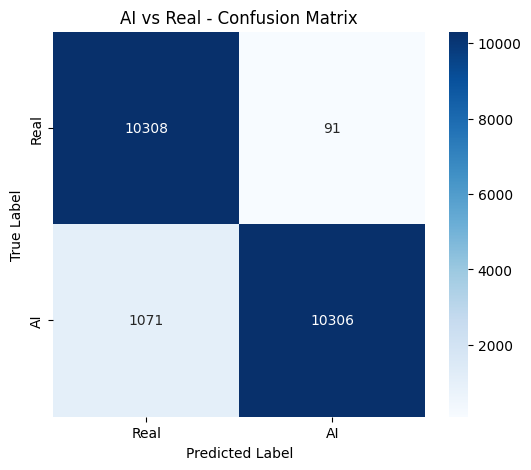

In [13]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'AI'], yticklabels=['Real', 'AI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('AI vs Real - Confusion Matrix')
plt.show()

In [14]:
import json

# Save the weights
model_path = "deepdetect_final_v1.pth"
torch.save(model.state_dict(), model_path)

# Save the class names mapping (Real=0, AI=1 or vice versa)
# datasets.ImageFolder assigns labels based on folder names alphabetically
class_names = full_train_ds.classes 
mapping = {i: name for i, name in enumerate(class_names)}

with open('class_mapping.json', 'w') as f:
    json.dump(mapping, f)

print(f"Files saved: {model_path} and class_mapping.json")

Files saved: deepdetect_final_v1.pth and class_mapping.json
